In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras as keras

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

# Data loading and generation

In [2]:
training_set_annotations = pd.read_csv('training_data/annotations.csv').drop('Unnamed: 0', axis=1).set_index('file_path').fillna(method = 'ffill')
keypoints_names = list(dict.fromkeys(["_".join(index_name.split("_")[:-1]) for index_name in training_set_annotations.columns]))
training_set_annotations.columns

C:\Users\Legion\AppData\Local\Temp\ipykernel_11688\4072160914.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_set_annotations = pd.read_csv('training_data/annotations.csv').drop('Unnamed: 0', axis=1).set_index('file_path').fillna(method = 'ffill')


Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [3]:
training_set_annotations.iloc[:5]

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
file_path                                                             
0.jpg               0.687850           0.406274            0.314865   
1.jpg               0.670135           0.364272            0.311972   
2.jpg               0.677678           0.363642            0.321914   
3.jpg               0.679435           0.388143            0.333574   
4.jpg               0.695055           0.412721            0.335883   

           right_eye_center_y  left_eye_inner_corner_x  \
file_path                                                
0.jpg                0.379392                 0.620647   
1.jpg                0.348424                 0.613085   
2.jpg                0.363642                 0.618875   
3.jpg                0.388143                 0.625035   
4.jpg                0.396271                 0.610061   

           left_eye_inner_corner_y  left_eye_outer_corner_x  \
file_path                                                     
0.jpg                     0.412994                 0.761774   
1.jpg                     0.367441                 0.736695   
2.jpg                     0.378343                 0.739421   
3.jpg                     0.407575                 0.753278   
4.jpg                     0.412721                 0.755374   

           left_eye_outer_corner_y  right_eye_inner_corner_x  \
file_path                                                      
0.jpg                     0.416354                  0.378714   
1.jpg                     0.376950                  0.375362   
2.jpg                     0.378343                  0.392480   
3.jpg                     0.399802                  0.391861   
4.jpg                     0.415463                  0.385233   

           right_eye_inner_corner_y  ...  nose_tip_x  nose_tip_y  \
file_path                            ...                           
0.jpg                      0.389473  ...    0.462714    0.594446   
1.jpg                      0.357933  ...    0.502149    0.579801   
2.jpg                      0.378343  ...    0.495388    0.557697   
3.jpg                      0.403689  ...    0.540470    0.564235   
4.jpg                      0.407238  ...    0.451037    0.675933   

           mouth_left_corner_x  mouth_left_corner_y  mouth_right_corner_x  \
file_path                                                                   
0.jpg                 0.637451             0.833023              0.298068   
1.jpg                 0.587723             0.795333              0.365858   
2.jpg                 0.633572             0.760566              0.351316   
3.jpg                 0.683322             0.757330              0.387974   
4.jpg                 0.631994             0.807534              0.324914   

           mouth_right_corner_y  mouth_center_top_lip_x  \
file_path                                                 
0.jpg                  0.806135                0.451173   
1.jpg                  0.792163                0.486298   
2.jpg                  0.757625                0.492447   
3.jpg                  0.772870                0.523991   
4.jpg                  0.802055                0.468362   

           mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
file_path                                                      
0.jpg                    0.759744                   0.449278   
1.jpg                    0.731943                   0.473624   
2.jpg                    0.731164                   0.492447   
3.jpg                    0.730122                   0.537096   
4.jpg                    0.767785                   0.460699   

           mouth_center_bottom_lip_y  
file_path                             
0.jpg                       0.880060  
1.jpg                       0.890418  
2.jpg                       0.819368  
3.jpg                       0.815296  
4.jpg                       0.904908  

[5 rows x 30 columns]

# Data augmentations

In [4]:
INPUT_SIZE = (288, 288, 1)

train_aug = iaa.Sequential(
    [
        iaa.Resize(INPUT_SIZE[:2], interpolation="linear"),
        iaa.Fliplr(0.3),
        iaa.Sometimes(0.1, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
        iaa.Sometimes(0.1, iaa.Affine(rotate=350, scale=(0.5, 0.7))),
        iaa.Sometimes(0.1, iaa.Affine(rotate=30, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(INPUT_SIZE[:2], interpolation="linear")])

In [5]:
def model_output_to_keypoints_coordinates(output: np.array) -> dict:
    ret = {}
    for i, keypoint_name in enumerate(keypoints_names):
        keypoint_coordinates = output[0][(i*2):(2*i+2)]
        ret[keypoint_name] = keypoint_coordinates
    return ret

In [16]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        df: pd.DataFrame,
        images_path: str,
        batch_size: int,
        shuffle: bool = True,
        keys: list = None,
        aug: iaa.Augmenter = None
    ):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = [i for i in df.index]
        if keys is not None:
            self.indexes = [i for i in keys]
        self.datalen = len(self.indexes)
        self.images_path = images_path
        self.images = np.array([self._load_image(index) for index in self.indexes])
        self.keypoints = df.loc[self.indexes].to_numpy()
        self.indexes = np.arange(self.datalen)
        self.aug = aug
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _load_image(self, path: str) -> np.array:
        return cv2.cvtColor(
            cv2.imread(self.images_path + "/" + path), cv2.COLOR_BGR2GRAY
        )[:, :, np.newaxis]

    def __getitem__(self, index):
        # get batch indexes from shuffled indexes
        batch_indexes = self.indexes[
            index * self.batch_size : (index + 1) * self.batch_size
        ]
        keypoints = self.keypoints[batch_indexes]
        images = self.images[batch_indexes]
        # Data augmentation
        if self.aug is not None:
            images = np.empty((self.batch_size,) + INPUT_SIZE)
            keypoints = np.empty((self.batch_size,)+(len(keypoints_names)*2,))
            for i, (image, keypoints_img) in enumerate(zip(self.images[batch_indexes], self.keypoints[batch_indexes])):
                kps = []
                for _, keyp in model_output_to_keypoints_coordinates([keypoints_img]).items():
                    kps.append(Keypoint(x = keyp[0] * image.shape[1], y = keyp[1] * image.shape[0]))
                kps_obj = KeypointsOnImage(kps, shape=image.shape)
                augmented_img, augmented_kps = self.aug(image = image, keypoints = kps_obj)
                images[i, ] = augmented_img
                keypoints_tmp = []
                for keypoint in augmented_kps:
                    keypoints_tmp.append(keypoint.x / INPUT_SIZE[1])
                    keypoints_tmp.append(keypoint.y / INPUT_SIZE[0])
                keypoints[i, ] = np.array(keypoints_tmp)
        return images, keypoints

    def __len__(self):
        # Denotes the number of batches per epoch
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)


gen = DataGenerator(training_set_annotations, "training_data", 32, aug = train_aug)
print("INPUT SHAPE", gen[0][0][0].shape)
print("OUTPUT SHAPE", gen[0][1][0].shape)
print(len(gen))

INPUT SHAPE (288, 288, 1)
OUTPUT SHAPE (30,)
220


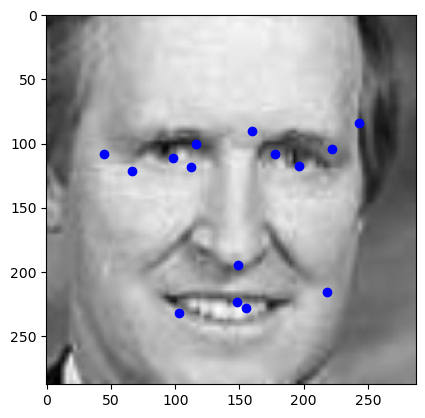

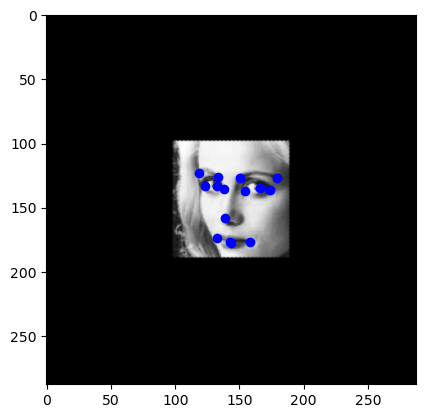

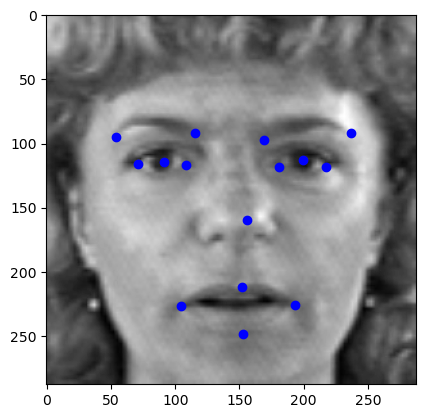

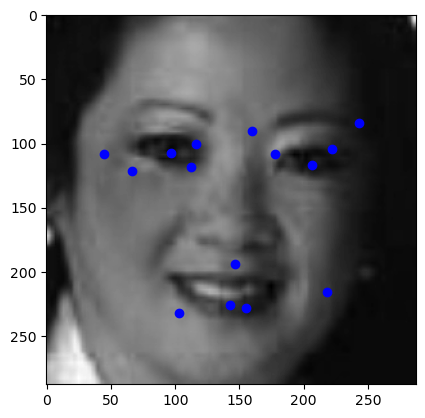

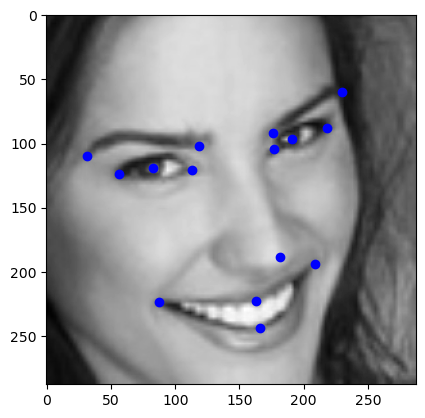

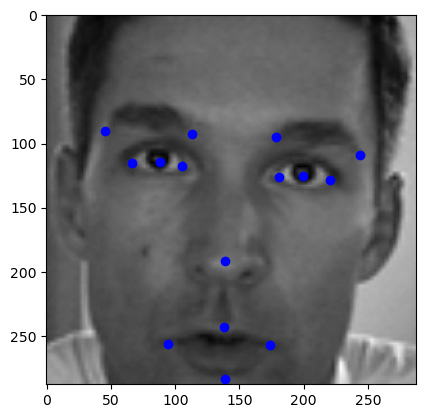

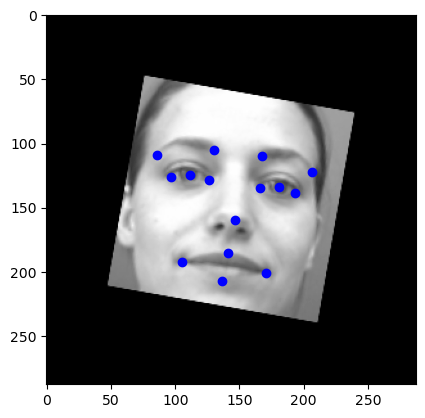

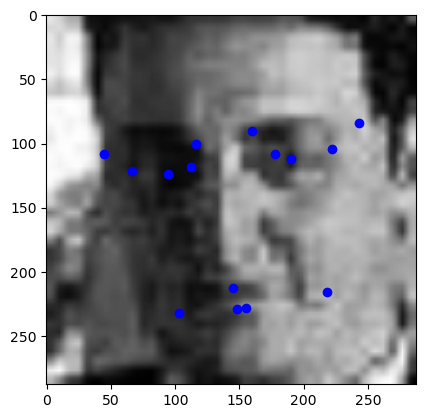

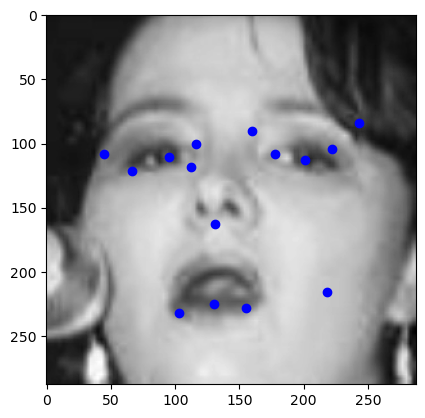

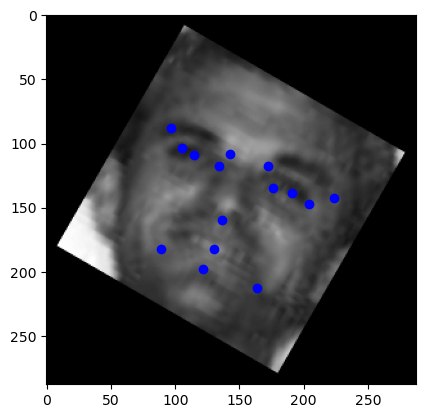

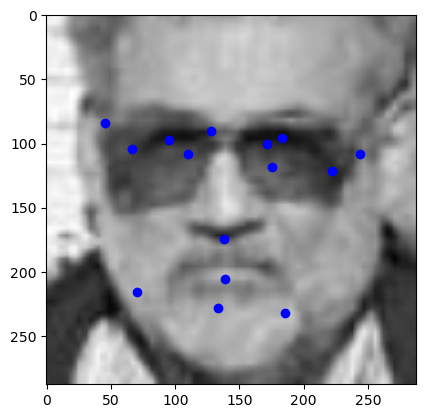

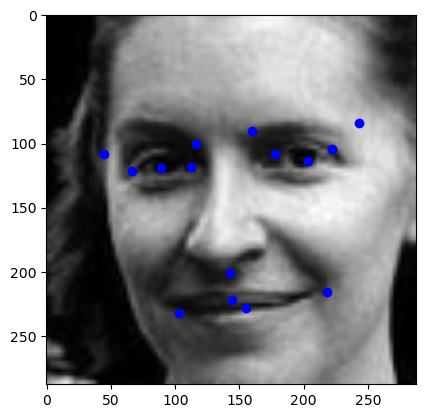

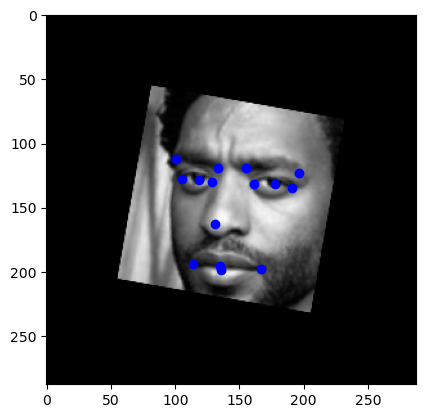

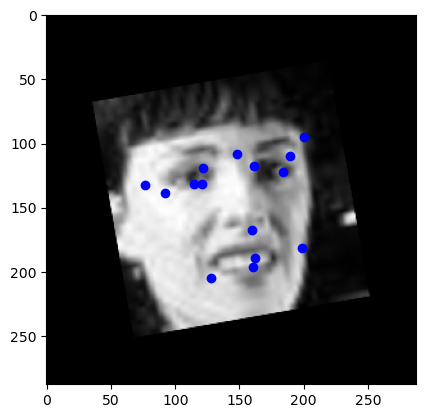

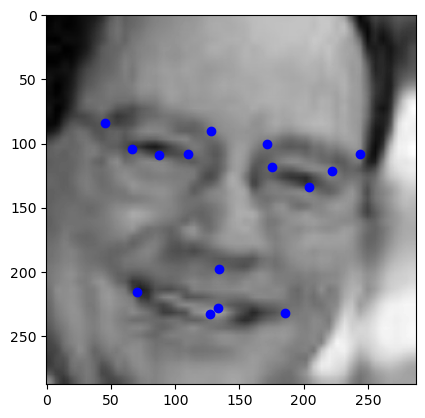

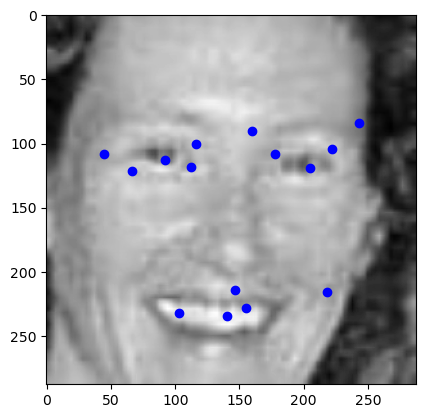

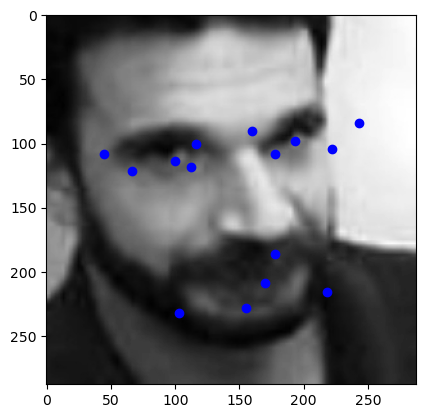

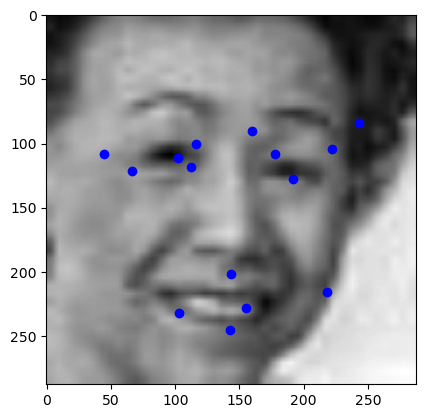

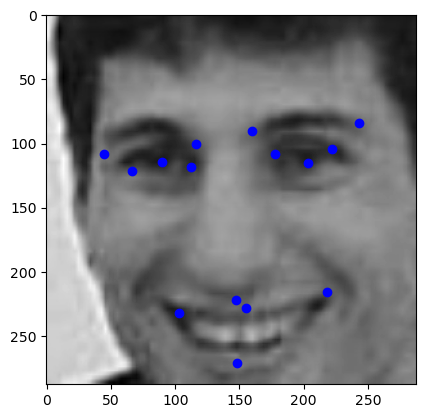

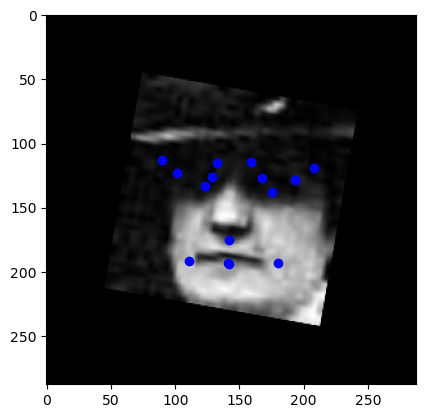

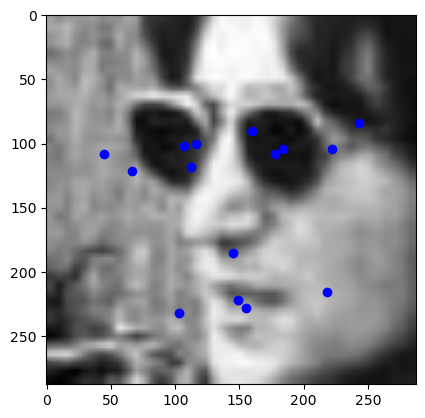

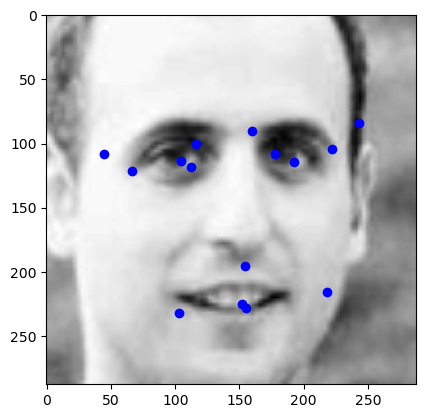

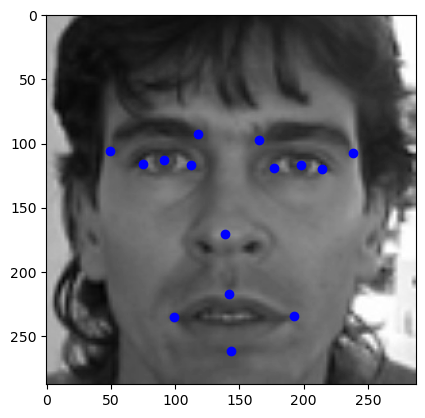

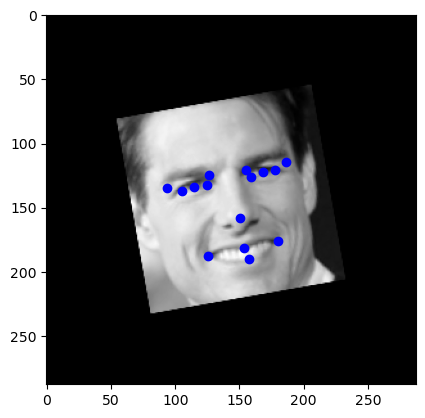

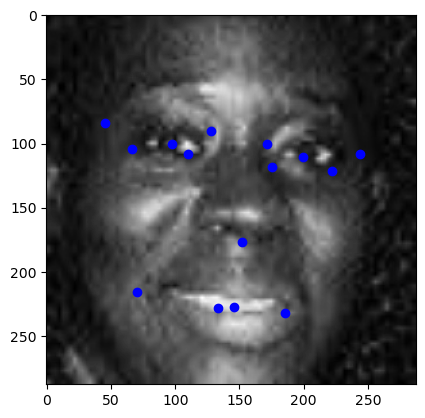

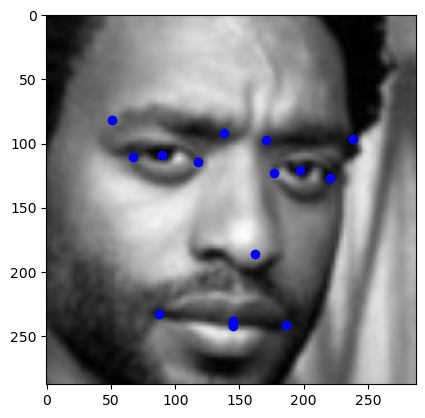

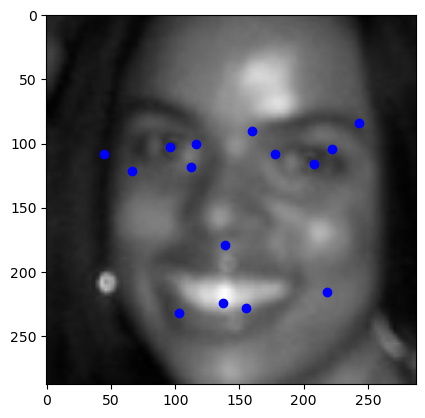

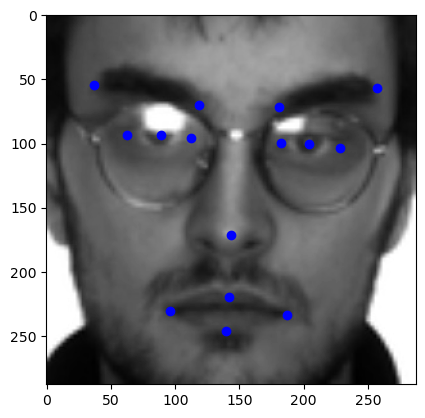

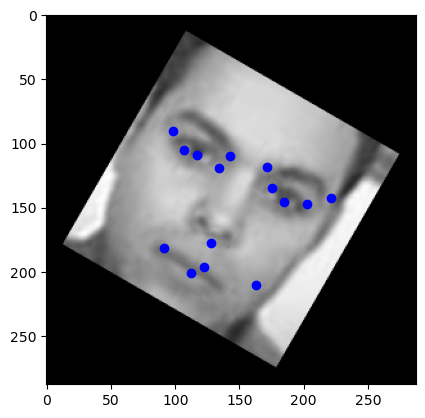

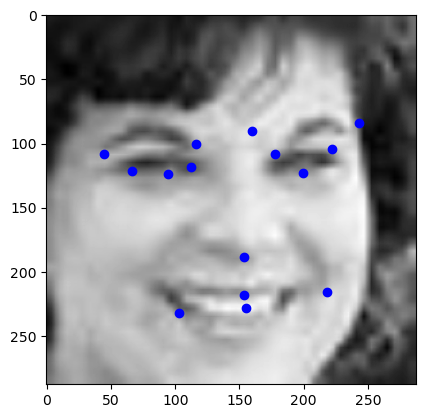

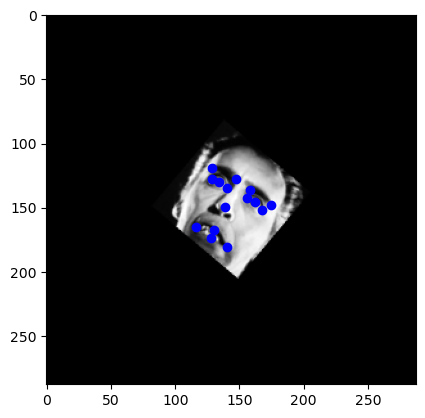

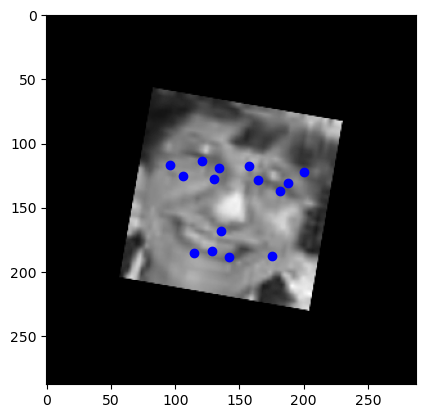

In [7]:
def display_image_with_keypoints(img: np.array, keypoints: list):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    keyps_reshaped = keypoints.reshape(-1, 2)
    ax.scatter(keyps_reshaped[:,0] * img.shape[1], keyps_reshaped[:,1] * img.shape[0], color='blue')
    plt.show()
    
imgs, keyps = gen[0]
for i in range(32):
    display_image_with_keypoints(imgs[i], keyps[i])

# Model training

In [8]:
BATCH_SIZE = 16
EPOCHS = 5

In [9]:
from sklearn.model_selection import train_test_split

train_val_keys, test_keys = train_test_split(training_set_annotations.index, test_size = 0.2)
train_keys, val_keys = train_test_split(train_val_keys, test_size=0.2)
training_set = DataGenerator(training_set_annotations, 'training_data', BATCH_SIZE, keys=train_keys, aug = train_aug)
validation_set = DataGenerator(training_set_annotations, 'training_data', BATCH_SIZE, keys=val_keys, aug = test_aug)

test_set = DataGenerator(training_set_annotations, 'training_data', BATCH_SIZE, keys = test_keys, aug = test_aug)

### Model 1

In [11]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense

model1 = Sequential()

model1.add(Convolution2D(128, (3, 3), input_shape = INPUT_SIZE, activation = 'leaky_relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())

model1.add(Convolution2D(64, (3, 3), activation = 'tanh'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())

model1.add(Convolution2D(32, (3, 3), activation = 'leaky_relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())

model1.add(Convolution2D(16, (3, 3), activation = 'tanh'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())

model1.add(Convolution2D(8, (3, 3), activation = 'leaky_relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())

model1.add(Flatten())
model1.add(Dense(64, activation = 'leaky_relu'))
model1.add(Dense(30, activation = 'sigmoid'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 286, 286, 128)     1280      
                                                                 
 batch_normalization_4 (Bat  (None, 286, 286, 128)     512       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 143, 143, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 141, 141, 64)      73792     
                                                                 
 batch_normalization_5 (Bat  (None, 141, 141, 64)      256       
 chNormalization)                                                
                                                      

In [17]:
def compile_and_train(
    model: keras.Model,
    optimizer: keras.optimizers.Optimizer,
    loss: keras.losses.Loss,
    model_name: str = "model",
) -> keras.Model:
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=f"checkpoint_{model_name}_{optimizer._name}_{loss.__name__}.keras",
        monitor="val_loss",
        mode="auto",
        save_best_only=True,
    )
    model_early_callback = keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        restore_best_weights = True
    )
    print(optimizer._name, loss.__name__)
    model.compile(optimizer=optimizer, loss=loss, metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsolutePercentageError(), keras.metrics.MeanAbsoluteError()])
    model.fit(
        training_set,
        epochs=EPOCHS,
        validation_data=validation_set,
        callbacks=[model_checkpoint_callback, model_early_callback],
        workers=8,
        use_multiprocessing=False,
        max_queue_size=32
    )
    model.save(f"{model_name}_{optimizer._name}_{loss.__name__}.keras")
    return model

In [18]:
optimizers_to_check = [
    keras.optimizers.legacy.Adam(),
    keras.optimizers.legacy.RMSprop(),
    keras.optimizers.legacy.SGD()
]

losses_to_check = [
    keras.losses.mean_squared_error,
    keras.losses.mean_absolute_error,
    keras.losses.mean_absolute_percentage_error
]

In [19]:
for optimizer in optimizers_to_check:
    for loss in losses_to_check:
        compile_and_train(model1, optimizer, loss, "model1")

Adam mean_squared_error
Epoch 1/5
281/281 [==============================] - 892s 3s/step - loss: 0.0168 - root_mean_squared_error: 0.1298 - mean_absolute_percentage_error: 22.4135 - mean_absolute_error: 0.0880 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702 - val_mean_absolute_percentage_error: 13.8270 - val_mean_absolute_error: 0.0512
Epoch 2/5
281/281 [==============================] - 863s 3s/step - loss: 0.0140 - root_mean_squared_error: 0.1184 - mean_absolute_percentage_error: 19.6788 - mean_absolute_error: 0.0758 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895 - val_mean_absolute_percentage_error: 17.4492 - val_mean_absolute_error: 0.0639
Adam mean_absolute_error
Epoch 1/5
281/281 [==============================] - 791s 3s/step - loss: 0.0660 - root_mean_squared_error: 0.1336 - mean_absolute_percentage_error: 16.9748 - mean_absolute_error: 0.0660 - val_loss: 0.0534 - val_root_mean_squared_error: 0.0693 - val_mean_absolute_percentage_error: 14.0892 - val_mean_ab

KeyboardInterrupt: 

In [20]:
def load_model_from_weights(path: str) -> keras.Model:
    return keras.models.load_model(path)

In [50]:
model1 = load_model_from_weights('model1_RMSprop_mean_absolute_error.keras')

In [51]:
model1.evaluate(test_set)

10/88 [==>...........................] - ETA: 48s - loss: 0.0175 - root_mean_squared_error: 0.0298 - mean_absolute_percentage_error: 4.0939 - mean_absolute_error: 0.0175

KeyboardInterrupt: 

In [58]:
img = test_set[0][0][3]
res = model1.predict(np.array([img]))

1/1 [==============================] - 0s 92ms/step


In [59]:
res

array([[0.69239956, 0.39099255, 0.31987497, 0.3847882 , 0.61748654,
        0.3844778 , 0.7564991 , 0.37379003, 0.39300713, 0.40757042,
        0.22954871, 0.4117749 , 0.54861695, 0.3185774 , 0.8295582 ,
        0.30075532, 0.41399252, 0.33606032, 0.16057411, 0.35487625,
        0.50404966, 0.66899174, 0.6923218 , 0.7691102 , 0.35890046,
        0.81402296, 0.5200891 , 0.7991816 , 0.5082349 , 0.8397488 ]],
      dtype=float32)

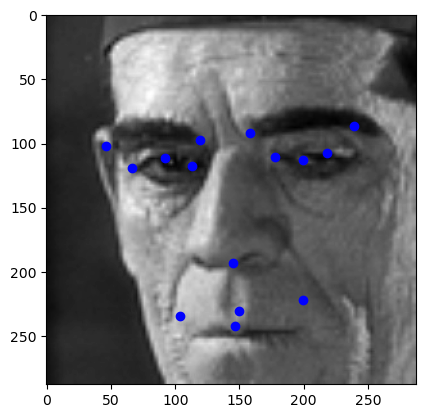

In [60]:
display_image_with_keypoints(img, res)

# Filters

In [53]:
keypoints_names

['left_eye_center',
 'right_eye_center',
 'left_eye_inner_corner',
 'left_eye_outer_corner',
 'right_eye_inner_corner',
 'right_eye_outer_corner',
 'left_eyebrow_inner_end',
 'left_eyebrow_outer_end',
 'right_eyebrow_inner_end',
 'right_eyebrow_outer_end',
 'nose_tip',
 'mouth_left_corner',
 'mouth_right_corner',
 'mouth_center_top_lip',
 'mouth_center_bottom_lip']

left_eye_center


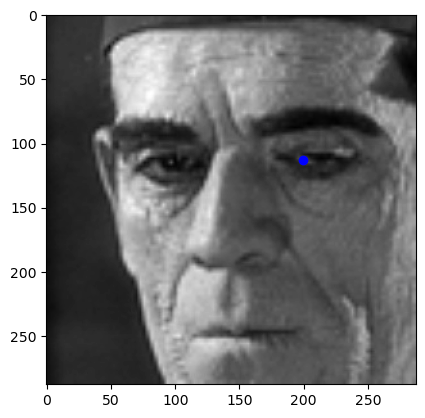

right_eye_center


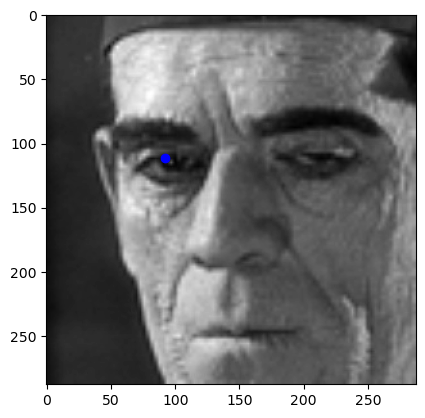

left_eye_inner_corner


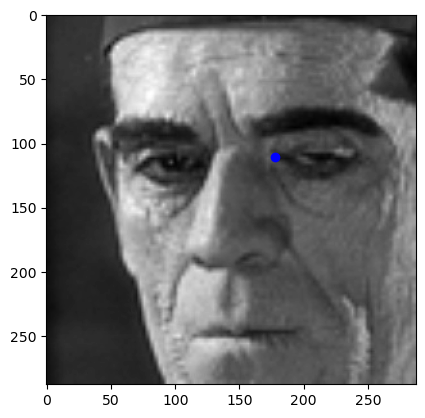

left_eye_outer_corner


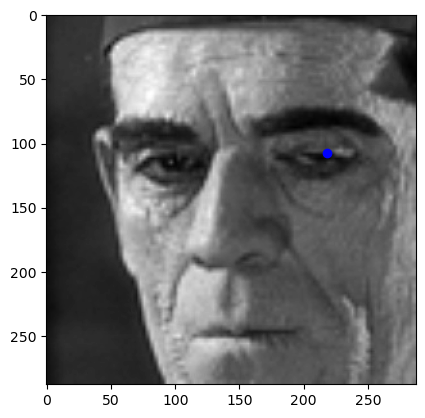

right_eye_inner_corner


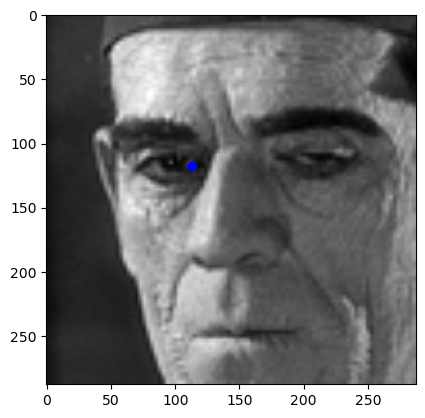

right_eye_outer_corner


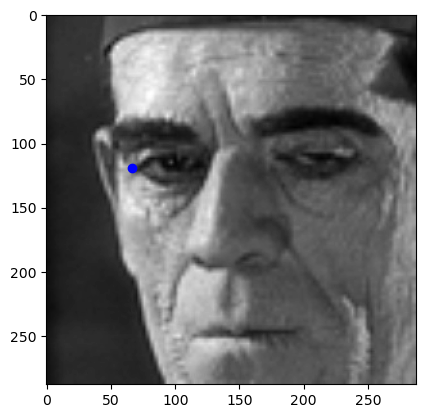

left_eyebrow_inner_end


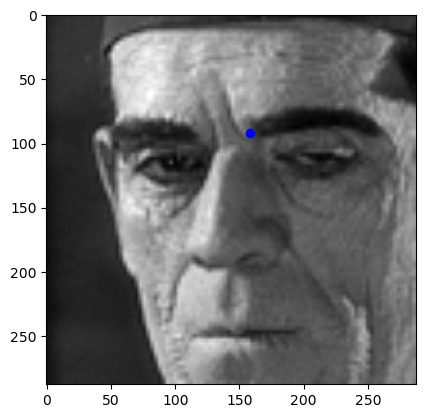

left_eyebrow_outer_end


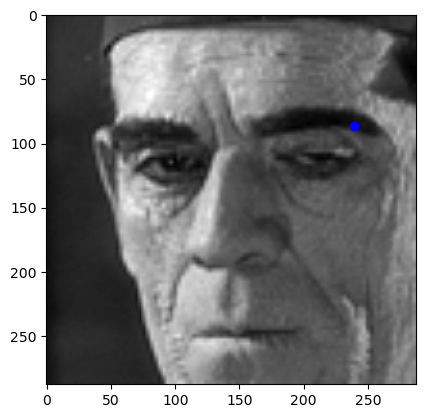

right_eyebrow_inner_end


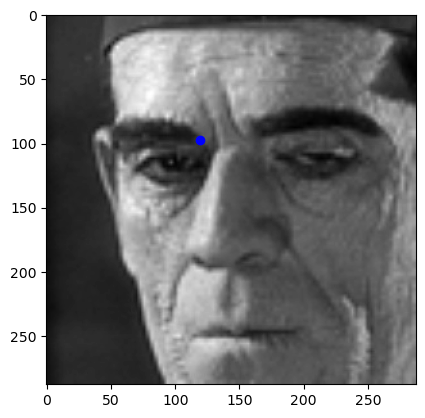

right_eyebrow_outer_end


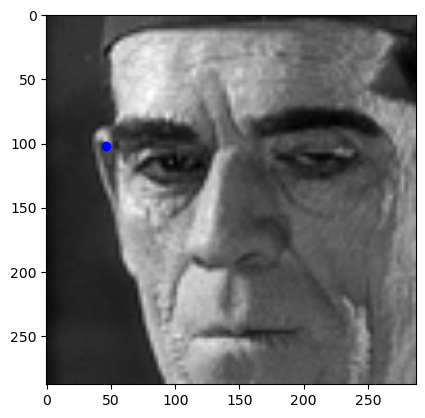

nose_tip


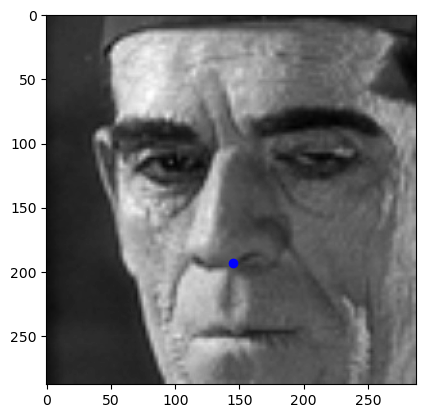

mouth_left_corner


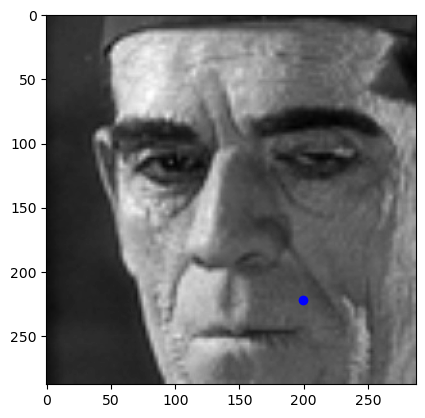

mouth_right_corner


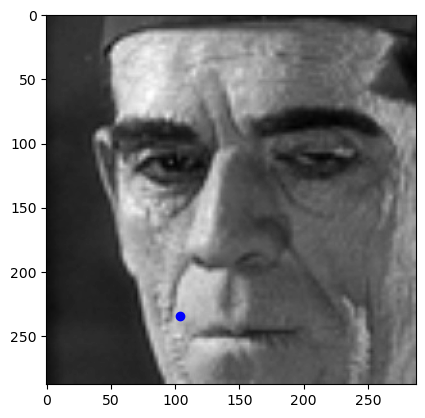

mouth_center_top_lip


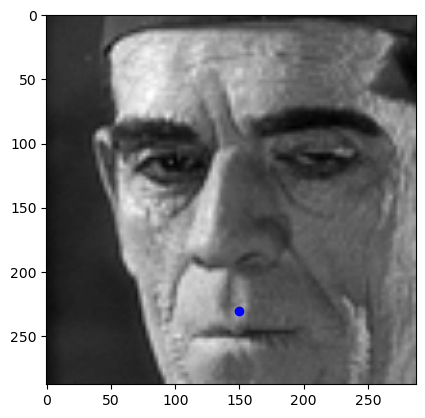

mouth_center_bottom_lip


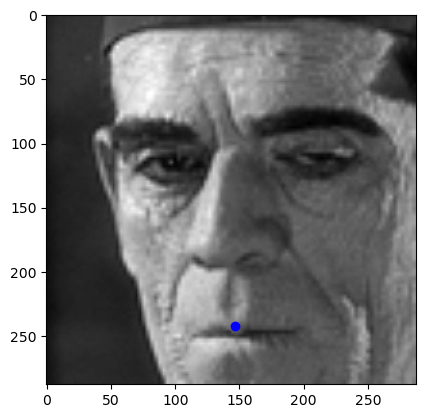

In [61]:
keyps = model_output_to_keypoints_coordinates(res)
for key_name in keypoints_names:
    print(key_name)
    display_image_with_keypoints(img, keyps[key_name])

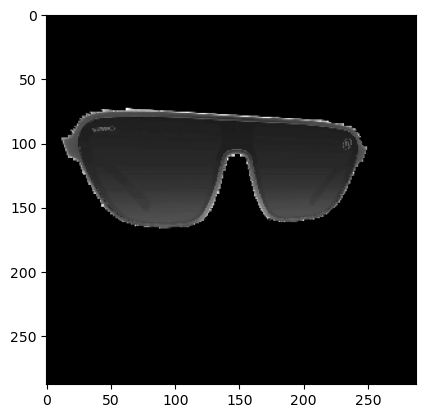

In [62]:
import json

class Filter:
    def __init__(self, json_descr_path: str):
        with open(json_descr_path, 'r') as f:
            data = json.load(f)
            self.image = cv2.imread(f"filters/{data['file_path']}")
            self.ref_points = data['reference_points']
    def show_image(self):
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
    def warp_to_points(self, points: dict) -> np.array:
        dst = []
        src = []
        for keypoint_name in self.ref_points:
            if keypoint_name in points:
                dst.append(points[keypoint_name] * INPUT_SIZE[0])
                src.append(self.ref_points[keypoint_name])
        assert len(dst) == len(src) == 4
        src = np.array(src, dtype=np.float32)
        dst = np.array(dst, dtype=np.float32)
        matrix = cv2.getPerspectiveTransform(src, dst)
        return cv2.warpPerspective(self.image, matrix, (INPUT_SIZE[0], INPUT_SIZE[1]), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

glasses = Filter('filters/sunglasses.json')
glasses_warped = cv2.cvtColor(glasses.warp_to_points(keyps), cv2.COLOR_BGR2GRAY)
plt.imshow(glasses_warped, cmap='gray')

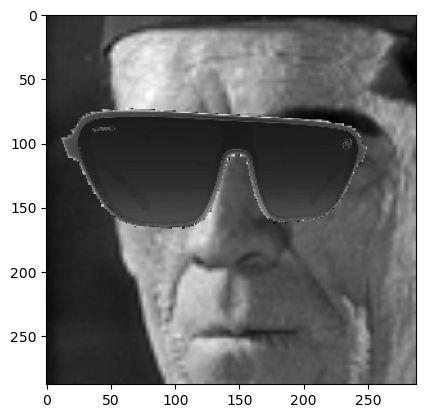

In [63]:
def combine_image_and_filter(img: np.array, filter: np.array) -> np.array:
    pseudo_alpha_filter = (filter > 0).astype(np.uint8)
    inverse_pseudo_alpha_filter = np.ones(INPUT_SIZE[:2]) - pseudo_alpha_filter
    return filter * pseudo_alpha_filter + inverse_pseudo_alpha_filter * img.squeeze()

plt.imshow(combine_image_and_filter(img, glasses_warped), cmap = 'gray')